In [58]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style='darkgrid')
import pandas as pd
import numpy as np

In [63]:
df = pd.read_csv('Data/Price_5m.csv')
df.time_m = pd.to_datetime(df.time_m)
price = df.groupby(df.time_m.dt.date).price_avg.mean()

In [73]:
# DDOF == 0 OR 1 ?????
def RV(ser, w):
    roller = ser.rolling(window=w)
    return roller.std(ddof=1) * np.sqrt(365 / w)

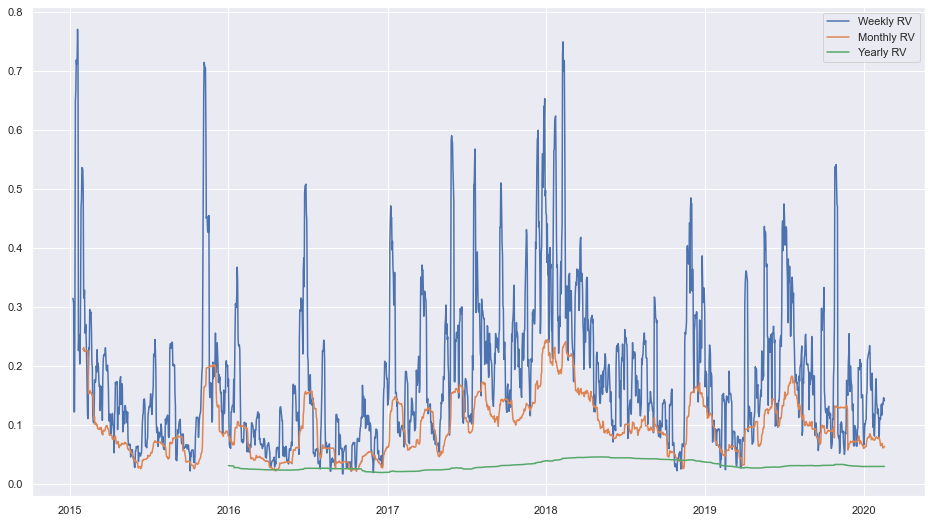

In [74]:
logret = np.log(price / price.shift())

rv7 = RV(logret, 7)
rv30 = RV(logret, 30)
rv365 = RV(logret, 365)

fig, ax = plt.subplots(1, 1, figsize=(16, 9))
ax.plot(rv7, label='Weekly RV')
ax.plot(rv30, label='Monthly RV')
ax.plot(rv365, label='Yearly RV')
plt.legend()
plt.show()